## Topological Polygons and Plate Boundaries

This notebook goes through some examples of how to work with topological plate polygons using pygplates.

For a general overview of what topological plate polygons are, see the paper by Gurnis et al (2012)
http://www.sciencedirect.com/science/article/pii/S0098300411001464

The topology function requires that you have a gpml file (or files) that define geometries that make up the plate boundaries, and also define how these geometries combine together to make polygons at any given moment in geological time. Within GPlates, the plate polygons are 'resolved' by piecing together the various boundary segments from individual geometries and removing any excess line sections. The pygplates function 'resolve_topologies' does the same thing within python.

In [1]:
import pygplates

rotation_filename = 'Data/Seton_etal_ESR2012_2012.1.rot'

input_topology_filename = 'Data/Seton_etal_ESR2012_PP_2012.1.gpmlz'

topology_features = pygplates.FeatureCollection(input_topology_filename)
rotation_model = pygplates.RotationModel(rotation_filename)

# Specify time at which to create resolved topological plate polygons
time=100.
resolved_topologies = []
pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time)


The above code has created a set of features containing the resolved topological plate polygons at 100 Ma. We can look at some of the properties of these polygons, for example finding out how many polygons there are and getting the plateid, name and area of each polygon.


In [2]:
# the number of plates is the length of the resolved topologies object 
num_plates = len(resolved_topologies)
print 'Number of Plates is ',num_plates

# Create empty lists of plate_id and area to which we will append these values for each resolved polygon
plate_ids = []
plate_names = []
plate_areas = []

for topology in resolved_topologies:
    # Get the plate_id and name
    plate_feature = topology.get_resolved_feature()
    plate_ids.append(plate_feature.get_reconstruction_plate_id())
    plate_names.append(plate_feature.get_name())
    # Get the plate area - note we use the built in pygplates Earth radius to get 
    plate_geometry = topology.get_resolved_geometry()
    plate_areas.append(plate_geometry.get_area()*pygplates.Earth.mean_radius_in_kms*pygplates.Earth.mean_radius_in_kms)

    

Number of Plates is  21


The cell below creates a plot visualising the area of each plate polygon (labelled according to the information taken from the gpml file).

Note that by changing the 'time' parameter above, we can run this process again and remake the plot for any time (though it is safest to stick to integer time values to ensure topologies are correctly resolved).

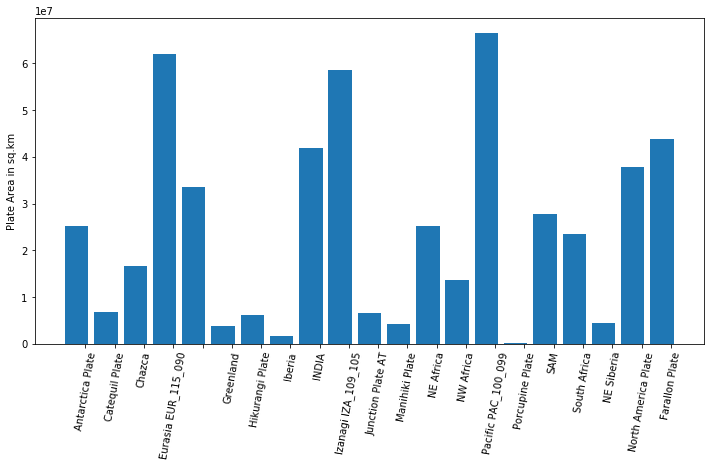

In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

label_index = np.arange(0,len(plate_areas))

plt.figure(figsize=(12,6))
plt.bar(label_index,plate_areas)
plt.xticks(label_index+0.3,plate_names,rotation=80)
plt.ylabel('Plate Area in sq.km')
plt.show()


##### Time-dependent attributes of topological polygons 

To work on the topological plate polygons through time, we write a for loop. This example prints out the number of polygons at 10 Myr intervals

In [4]:
max_time = 100
time_step = 10

for time in np.arange(0,max_time + 1,time_step):
    resolved_topologies = []
    pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time)
    print 'number of plate polygons at %s Ma is %s' % (time,len(resolved_topologies))


number of plate polygons at 0 Ma is 27
number of plate polygons at 10 Ma is 28
number of plate polygons at 20 Ma is 27
number of plate polygons at 30 Ma is 25
number of plate polygons at 40 Ma is 25
number of plate polygons at 50 Ma is 21
number of plate polygons at 60 Ma is 20
number of plate polygons at 70 Ma is 19
number of plate polygons at 80 Ma is 17
number of plate polygons at 90 Ma is 21
number of plate polygons at 100 Ma is 21


As well as looking at closed plate polygons, the resolved topologies can also be analysed to extract line segments that are attributed with the type of plate boundary - typically these are either subduction zone segments or ridge-transform boundary segments, with some other types also appearing (e.g. 'inferredPaleoBoundary').

The next section of code works on resolved topologies at 2 Myr increments from present-day to 200 Ma. Within each iteration, the plate boundary segments attributed as 'SubductionZone' or 'MidOceanRidge' are extracted and their lengths are summed to get a total length for each time step. Repeating this calculation for all time steps gives an array containing these values as a function of time, which are plotted at the end.

In [5]:
RotFile_List = 'Data/Seton_etal_ESR2012_2012.1.rot'
topology_features = 'Data/Seton_etal_ESR2012_PP_2012.1.gpmlz'

rotation_model = pygplates.RotationModel(RotFile_List)

max_time = 200
time_step = 2

SZ_length = []
RT_length = []

# 'time' = 0, 1, 2, ... , 140
for time in np.arange(0,max_time + 1,time_step):

    # Resolve our topological plate polygons (and deforming networks) to the current 'time'.
    # We generate both the resolved topology boundaries and the boundary sections between them.
    resolved_topologies = []
    shared_boundary_sections = []
    pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time, shared_boundary_sections)

    # We will accumulate the total ridge and subduction zone lengths for the current 'time'.
    total_ridge_length = 0
    total_subduction_zone_length = 0

    # Iterate over the shared boundary sections.
    for shared_boundary_section in shared_boundary_sections:

        # Skip sections that are not ridges or subduction zones.
        if (shared_boundary_section.get_feature().get_feature_type() != pygplates.FeatureType.create_gpml('SubductionZone') and
            shared_boundary_section.get_feature().get_feature_type() != pygplates.FeatureType.create_gpml('MidOceanRidge')):
            continue

        # Iterate over the shared sub-segments to accumulate their lengths.
        shared_sub_segments_length = 0
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():

            # Each sub-segment has a polyline with a length.
            shared_sub_segments_length += shared_sub_segment.get_geometry().get_arc_length()

        # The shared sub-segments contribute either to the ridges or to the subduction zones.
        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('MidOceanRidge'):
            total_ridge_length += shared_sub_segments_length            
            
        else:
            total_subduction_zone_length += shared_sub_segments_length

    # The lengths are for a unit-length sphere so we must multiple by the Earth's radius.
    total_ridge_length_in_kms = total_ridge_length * pygplates.Earth.mean_radius_in_kms
    total_subduction_zone_length_in_kms = total_subduction_zone_length * pygplates.Earth.mean_radius_in_kms

    #print "At time %dMa, total ridge length is %f kms and total subduction zone length is %f kms." % (
    #        time, total_ridge_length_in_kms, total_subduction_zone_length_in_kms)
    SZ_length.append(total_subduction_zone_length_in_kms)
    RT_length.append(total_ridge_length_in_kms)



The length of each plate boundary type for each time step is stored in the 'SZ_length' and 'RT_length'. Plotting these numbers reveals the changing length of plate boundary types through time according to the topological model we are using.

[NB this can take a few minutes to calculate]

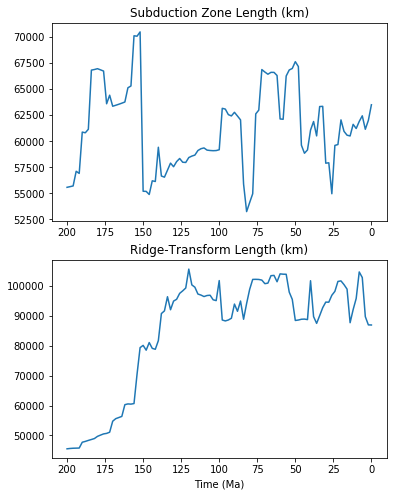

In [6]:
plt.figure(figsize=(6,8))
plt.subplot(211)
plt.plot(np.arange(0,max_time + 1,time_step),SZ_length)
plt.gca().invert_xaxis()
plt.title('Subduction Zone Length (km)')
plt.subplot(212)
plt.plot(np.arange(0,max_time + 1,time_step),RT_length)
plt.xlabel('Time (Ma)')
plt.gca().invert_xaxis()
plt.title('Ridge-Transform Length (km)')
plt.show()